In [2]:
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install mplfinance
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go

# feed is a dataframe of daily OHLC data


class Grab:
    def __init__(self, feed, M, fixed_N_near, fixed_N_far, use_close=False):
        # use_close is flag for improving the original exit procedure,
        # if use_close is true, we exit holding/shorted positions with close price instead
        self.use_close = use_close

        feed.loc[feed.index, "Trend"] = 0
        feed.loc[feed.index, "Near support"] = None
        feed.loc[feed.index, "Near resistance"] = None
        feed.loc[feed.index, "Far support"] = None
        feed.loc[feed.index, "Far resistance"] = None
        feed.loc[feed.index, "Shares"] = 0
        feed.loc[feed.index, "Price"] = None
        feed.loc[feed.index, "Cash"] = 0
        feed.loc[feed.index, "PnL"] = 0

        self.feed = feed

        self.M = M
        self.fixed_N_far = fixed_N_far
        self.fixed_N_near = fixed_N_near
        self.fixed_feed = feed.copy()
        # initial trend is undetermined, i.e. 0
        self.trend = 0
        # number of shares holding
        self.shares = 0
        # initial cash balance. Start with $0
        self.cash = 0
        # back test states, timestamp, shares, cash etc for (M-1)x (M-1) possible parameters
        self.bt_ts = None
        self.bt_shares = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_price = [[None for i in range(M-1)] for j in range(M-1)]
        self.bt_cash = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_pnl = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_trend = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_far_support = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_far_resistance = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_near_support = [[0 for i in range(M-1)] for j in range(M-1)]
        self.bt_near_resistance = [[0 for i in range(M-1)] for j in range(M-1)]
        # optimal parameters, will be updated in every iteration
        self.N_f = 2
        self.N_n = 1

    # find the optimal N_f, N_r
    def find_optimal_N(self):
        N_f = 2
        N_n = 1
        pnl = 0
        for N_far in range(2, self.M+1):
            for N_near in range(1, N_far):
                pnl2 = self.bt_pnl[N_far - 2][N_near - 1]
                if pnl2 is None:
                    print("Paise")
                # if this setting produce higher cash, then remember this setting
                if pnl2 > pnl:
                    pnl = pnl2
                    N_f = N_far
                    N_n = N_near
        return (N_f, N_n)

    def single_trade(self, ts, trend, shares, cash, N_far, N_near):
        data = self.feed.loc[:ts]
        market = data.iloc[-1]
        close = market["Close"]
        high = market["High"]
        low = market["Low"]
        price = None
        pnl = 0
        # get the hist feed, i.e. removing the current quote at time 'ts'
        hist = data.iloc[:-1]
        far = hist.tail(N_far)
        near = hist.tail(N_near)
        # calculate the far and near resistance and support level
        # for the next trade
        far_support = far["Low"].min()
        far_resistance = far["High"].max()
        near_support = near["Low"].min()
        near_resistance = near["High"].max()
        # decide trend
        prev_trend = trend
        if close > far_resistance:
            trend = 1
        elif close < far_support:
            trend = -1
        # if trend is not triggered yet, continue to next day
        # until trend is triggered (i.e. not equal to 0)
        if trend == 0:
            return (trend, shares, price, cash, pnl, far_support, far_resistance, near_support, near_resistance)
        # if trend is up
        if trend == 1:
            # if trend is switched, then exit any existing short positions
            # by buying back shorted position at near support level.
            # we are assuming we can always execute the trade at
            # the near support level.
            if prev_trend != trend and shares != 0:
                # record the profit and loss for the exit trade
                # note that this may not be executed in real trading environment
                # when trend is reversed, the buy back at near_resistance is far
                # below the spot price because spot is above the far resistance
                # level.
                # print(
                #     f"{ts}:{prev_trend}:{trend}: Exit buying back {shares} share at ${near_support}")
                price = close if self.use_close else near_resistance
                cash = cash + shares * price
                shares = 0  # exit all positons
            # if trend is not switched
            # and if the close price breaks the near support
            # and we are not holding any share, then buy one share
            # at the near support level (assuming trades can always be executed)
            elif close <= near_support and shares == 0:
                # print(
                #     f"{ts}:{prev_trend}:{trend}: Buying 1 share at ${near_support}")
                price = close if self.use_close else near_support
                shares = 1
                cash = cash - shares * price
            # if trend is not switched
            # and if close price breaks the near resistance
            # and we are holding a share, then sell the holding shares
            # at the near resistance level
            elif close >= near_resistance and shares != 0:
                # print(
                #     f"{ts}:{prev_trend}:{trend}: Selling 1 share at ${near_resistance}")
                price = close if self.use_close else near_resistance
                cash = cash + shares * price
                shares = 0
        elif trend == -1:
            # if trend is switched, then exit any existing long positions
            # by selling any holding position at near resistence level.
            # we are assuming we can always execute the trade at
            # the near support level.
            if prev_trend != trend and shares != 0:
                # record the profit and loss for the exit trade
                # note that this may not be executed in real trading environment
                # when trend is reversed, the selling at near_support
                # level is far above the spot price because spot is below
                # the far support level.
                # print(
                #     f"{ts}:{prev_trend}:{trend}: Exit selling {shares} share at ${near_resistance}")
                price = close if self.use_close else near_support
                cash = cash + shares * price
                shares = 0
            # if trend is not switched
            # and if close price breaks the near resistance
            # and we are not holding any share, then short sell a share
            # at the near resistance level
            elif close >= near_resistance and shares == 0:
                # print(
                #     f"{ts}:{prev_trend}:{trend}: Shorting 1 share at ${near_resistance}")
                price = close if self.use_close else near_resistance
                shares = -1
                cash = cash - shares * price
            # if trend is not switched
            # and if the close price breaks the near support
            # and we have short sell a share, then buy one share
            # at the near support level (assuming trades can always be executed)
            elif close <= near_support and shares != 0:
                # print(
                #     f"{ts}:{prev_trend}:{trend}: Buying 1 share at ${near_support}")
                price = close if self.use_close else near_support
                cash = cash + shares * price
                shares = 0
        pnl = cash + shares * close
        return (trend, shares, price, cash, pnl, far_support, far_resistance, near_support, near_resistance)

    def update_bt(self, ts):
        data = self.feed.loc[:ts]
        # we need at least M+1 previous quotes at the beginning
        if len(data) <= self.M:
            return False
        for N_far in range(2, self.M+1):
            for N_near in range(1, N_far):
                shares = self.bt_shares[N_far - 2][N_near - 1]
                cash = self.bt_cash[N_far - 2][N_near - 1]
                trend = self.bt_trend[N_far - 2][N_near - 1]
                trend, shares, price, cash, pnl, far_support, far_resistance, near_support, near_resistance = self.single_trade(
                    ts, trend, shares, cash, N_far, N_near)
                self.bt_ts = ts
                self.bt_trend[N_far - 2][N_near - 1] = trend
                self.bt_shares[N_far - 2][N_near - 1] = shares
                self.bt_price[N_far - 2][N_near - 1] = price
                self.bt_cash[N_far - 2][N_near - 1] = cash
                self.bt_pnl[N_far - 2][N_near - 1] = pnl

                self.bt_far_support[N_far - 2][N_near - 1] = far_support
                self.bt_far_resistance[N_far - 2][N_near - 1] = far_resistance
                self.bt_near_support[N_far - 2][N_near - 1] = near_support
                self.bt_near_resistance[N_far -
                                        2][N_near - 1] = near_resistance
        return True

    def trade(self):
        shares = 0
        cash = self.cash
        trend = 0
        for ts, row in self.feed.iterrows():
            # print(f">> {ts}")
            # find optimal N_far, N_near
            N_far, N_near = self.find_optimal_N()
            # update the trading states for all combinations of parameters
            if self.update_bt(ts) == False:
                continue
            # update fixed_feed
            self.fixed_feed.at[ts,
                               "Far support"] = self.bt_far_support[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Far resistance"] = self.bt_far_resistance[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Near support"] = self.bt_near_support[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Near resistance"] = self.bt_near_resistance[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Price"] = self.bt_price[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Cash"] = self.bt_cash[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "PnL"] = self.bt_pnl[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Trend"] = self.bt_trend[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts,
                               "Shares"] = self.bt_shares[self.fixed_N_far - 2][self.fixed_N_near - 1]
            self.fixed_feed.at[ts, "N_far"] = self.fixed_N_far
            self.fixed_feed.at[ts, "N_near"] = self.fixed_N_near

            # conduct trading with optimal params
            trend, shares, price, cash, pnl, far_support, far_resistance, near_support, near_resistance = self.single_trade(
                ts, trend, shares, cash, N_far, N_near)
            # update optimal trading history
            self.feed.at[ts,
                         "Far support"] = far_support
            self.feed.at[ts,
                         "Far resistance"] = far_resistance
            self.feed.at[ts,
                         "Near support"] = near_support
            self.feed.at[ts,
                         "Near resistance"] = near_resistance
            self.feed.at[ts,
                         "Price"] = price
            self.feed.at[ts,
                         "Cash"] = cash
            self.feed.at[ts,
                         "PnL"] = pnl
            self.feed.at[ts,
                         "Trend"] = trend
            self.feed.at[ts,
                         "Shares"] = shares
            self.feed.at[ts, "N_far"] = N_far
            self.feed.at[ts, "N_near"] = N_near

    def plot(self, trade_hist):
        mpf.plot(trade_hist, type='candle')
        plt.plot(trade_hist["Near support"], label="Near support")
        plt.plot(trade_hist["Near resistance"], label="Near resistance")
        plt.plot(trade_hist["Far support"], label="Far support")
        plt.plot(trade_hist["Far resistance"], label="Far resistance")
        # plt.plot(trade_hist["Shares"], label="Shares")
        plt.legend()
        plt.show()
        plt.plot(trade_hist["PnL"], label="PnL")
        plt.show()

    def plot2(self, trade_hist):
        fig = go.Figure(data=[go.Candlestick(x=trade_hist.index,
                                             open=trade_hist['Open'],
                                             high=trade_hist['High'],
                                             low=trade_hist['Low'],
                                             close=trade_hist['Close'], name="Candlestick")])
        fig.add_trace(go.Line(x=trade_hist.index,
                      y=trade_hist["Near support"], name="Near support"))
        fig.add_trace(go.Line(x=trade_hist.index,
                      y=trade_hist["Near resistance"], name="Near resistance"))
        fig.add_trace(go.Line(x=trade_hist.index,
                      y=trade_hist["Far support"], name="Far support"))
        fig.add_trace(go.Line(x=trade_hist.index,
                      y=trade_hist["Far resistance"], name="Far resistance"))
        # fig.add_line(x=trade_hist.index, y=trade_hist["Near support"])
        fig.show()


# msft = yf.Ticker("AAPL")
# hist = msft.history(start="2022-01-01", end="2022-06-01")
# hist = hist[["Open", "High", "Low", "Close"]]
# algo = Grab(hist, 50, 10, 20)
# algo.trade()

# algo.feed.to_csv("optimal_trade.csv")
# algo.fixed_feed.to_csv("fixed_trade.csv")
# algo.plot(algo.feed)


# # print(trade_hist.tail())
# print("Pause")


## AAPL

In [ ]:
msft = yf.Ticker("AAPL")
hist = msft.history(start="2015-01-01", end="2022-11-01")
hist = hist[["Open", "High", "Low", "Close"]]
algo = Grab(hist, 50, 10, 20, True)
algo.trade()
algo.feed.to_csv("aapl_optimal_trade_full.csv")
algo.fixed_feed.to_csv("aapl_fixed_trade_full.csv")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




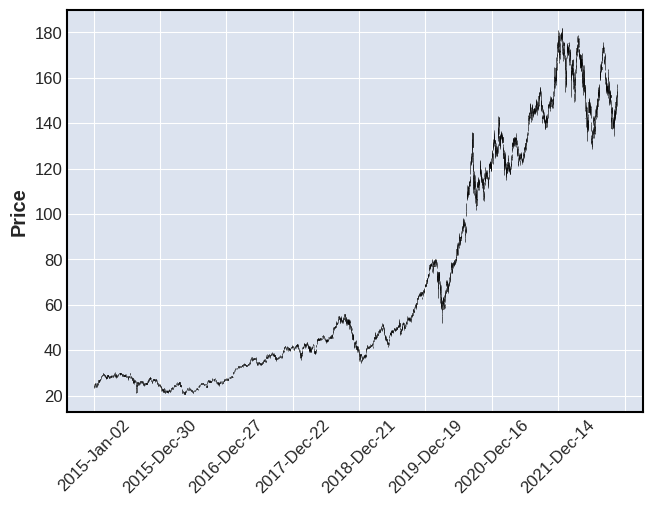

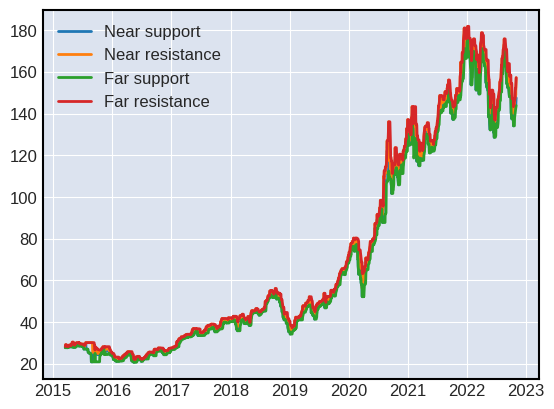

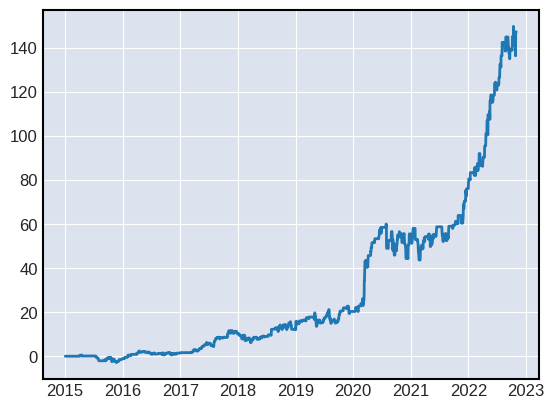

In [ ]:
algo.plot2(algo.feed)
algo.plot(algo.feed)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




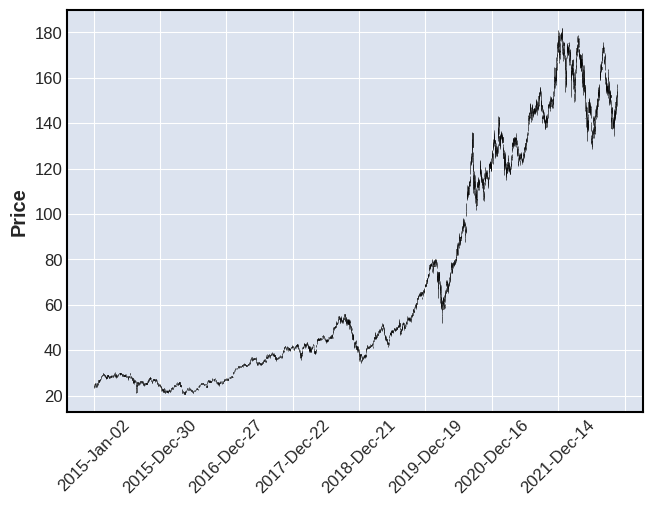

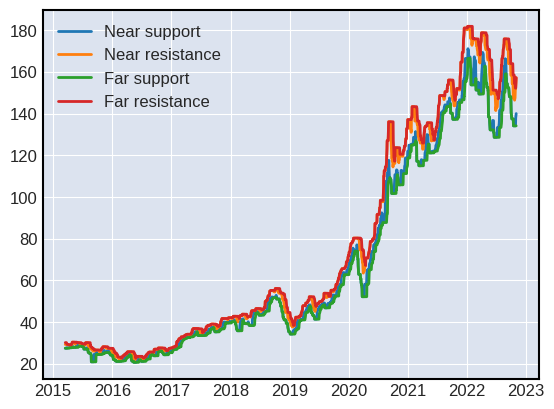

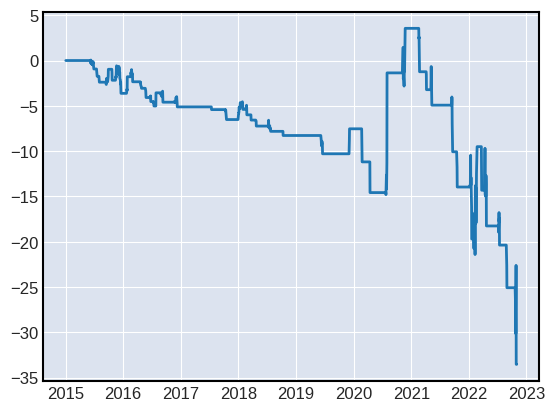

In [ ]:
algo.plot2(algo.fixed_feed)
algo.plot(algo.fixed_feed)

## ADMP

In [ ]:
msft = yf.Ticker("ADMP")
hist = msft.history(start="2015-01-01", end="2022-11-01")
hist = hist[["Open", "High", "Low", "Close"]]
algo = Grab(hist, 50, 10, 20, True)
algo.trade()
algo.feed.to_csv("admp_optimal_trade_full.csv")
algo.fixed_feed.to_csv("admp_fixed_trade_full.csv")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




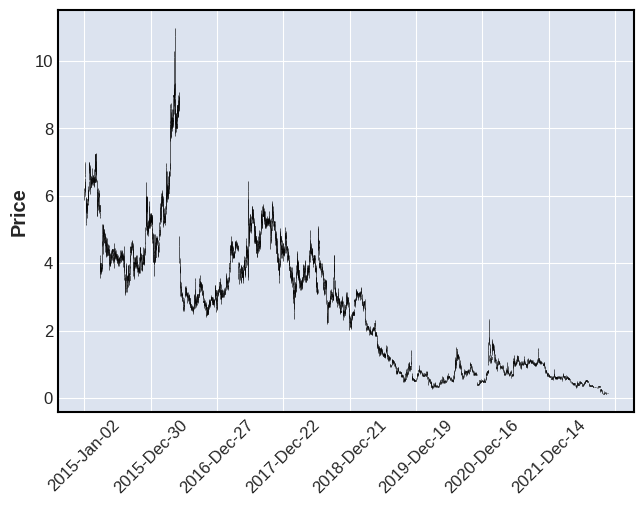

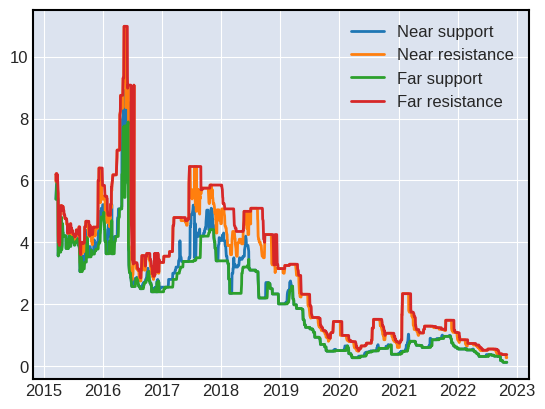

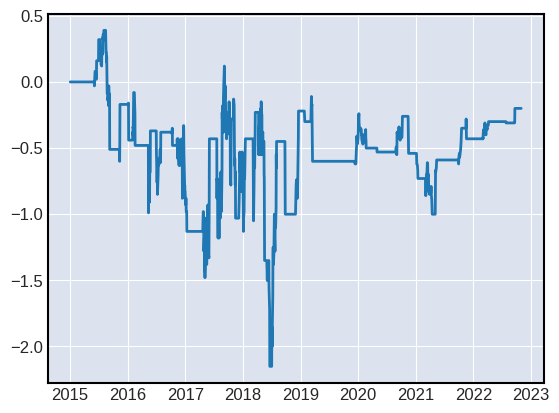

In [ ]:
algo.plot2(algo.feed)
algo.plot(algo.feed)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




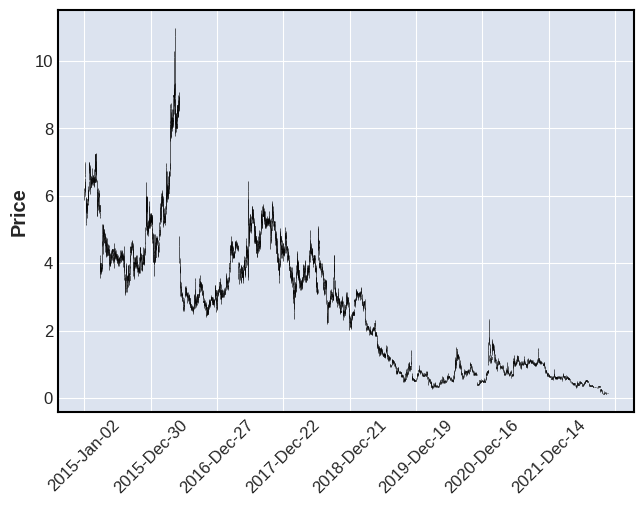

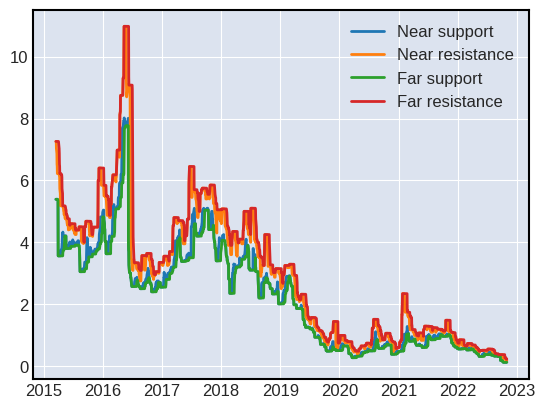

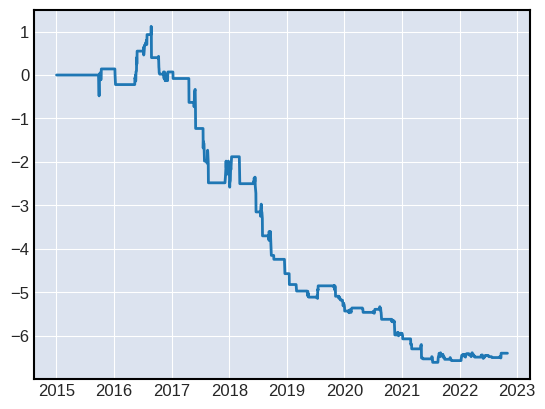

In [ ]:
algo.plot2(algo.fixed_feed)
algo.plot(algo.fixed_feed)

## MSFT

In [ ]:
msft = yf.Ticker("MSFT")
hist = msft.history(start="2015-01-01", end="2022-11-01")
hist = hist[["Open", "High", "Low", "Close"]]
algo = Grab(hist, 50, 10, 20, True)
algo.trade()
algo.feed.to_csv("msft_optimal_trade_full.csv")
algo.fixed_feed.to_csv("msft_fixed_trade_full.csv")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




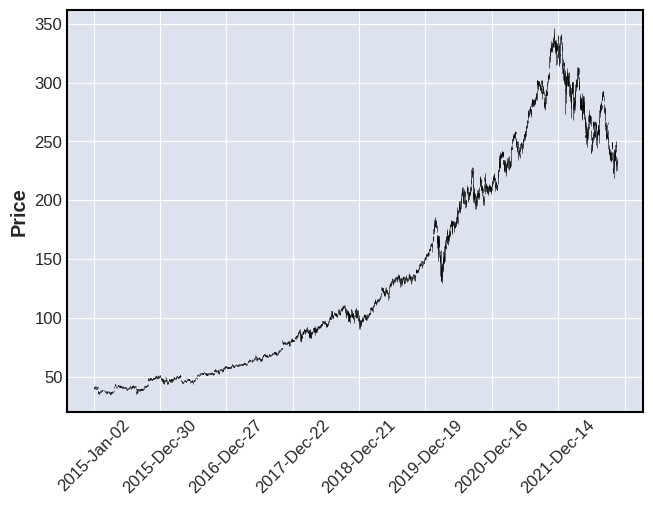

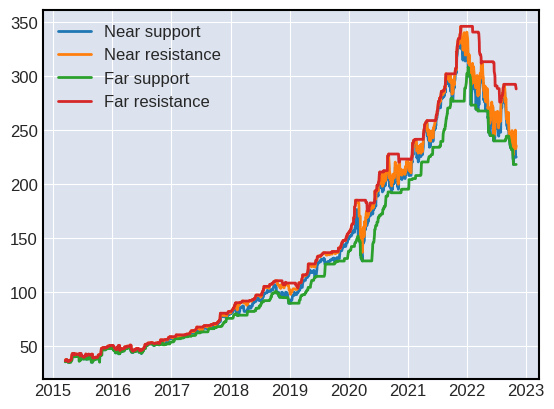

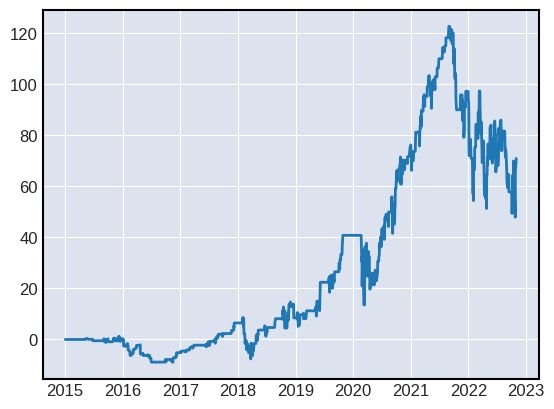

In [ ]:
algo.plot2(algo.feed)
algo.plot(algo.feed)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




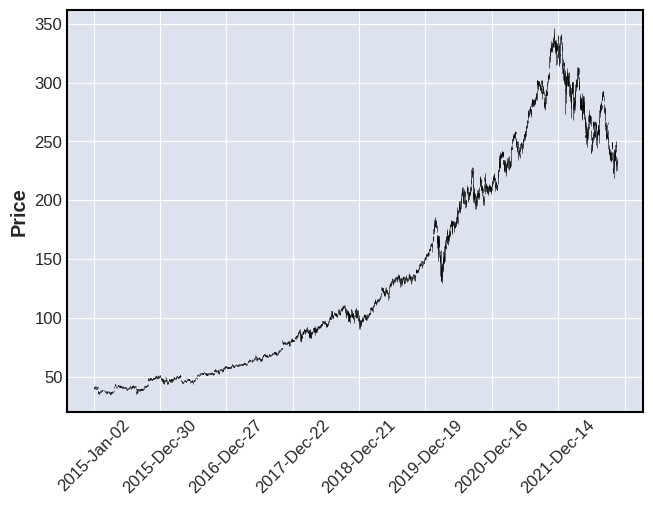

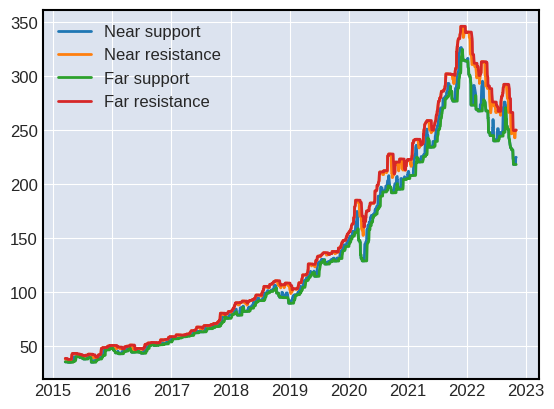

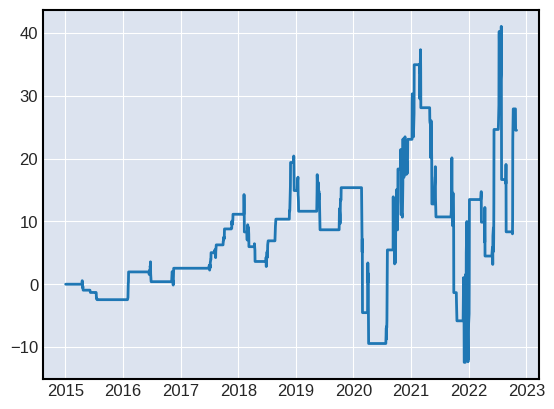

In [ ]:
algo.plot2(algo.fixed_feed)
algo.plot(algo.fixed_feed)

## TSLA

In [ ]:
msft = yf.Ticker("TSLA")
hist = msft.history(start="2015-01-01", end="2022-11-01")
hist = hist[["Open", "High", "Low", "Close"]]
algo = Grab(hist, 50, 10, 20, True)
algo.trade()
algo.feed.to_csv("tsla_optimal_trade_full.csv")
algo.fixed_feed.to_csv("tsla_fixed_trade_full.csv")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




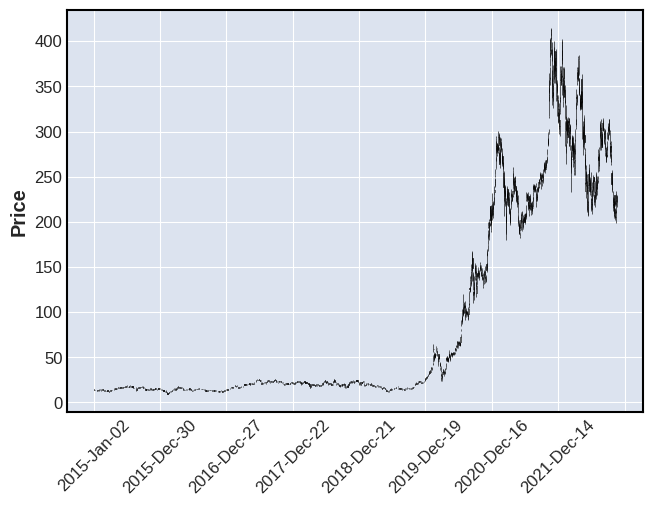

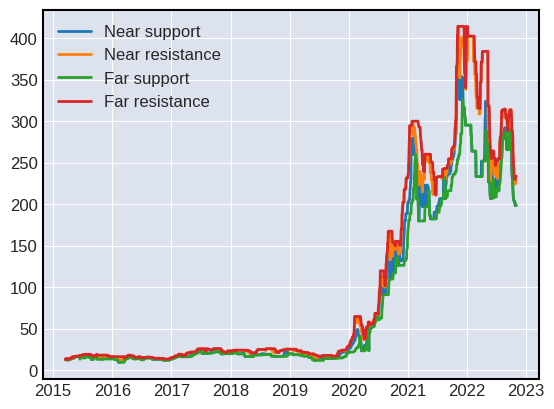

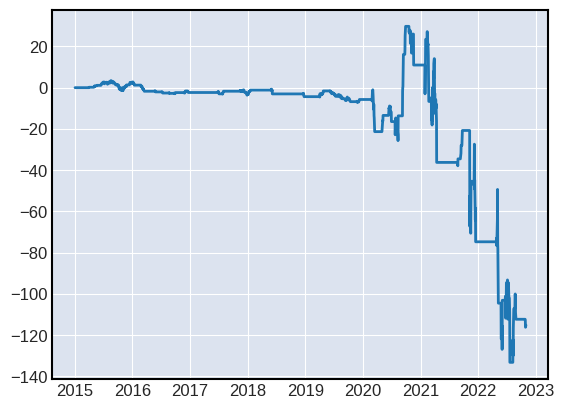

In [ ]:
algo.plot2(algo.feed)
algo.plot(algo.feed)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




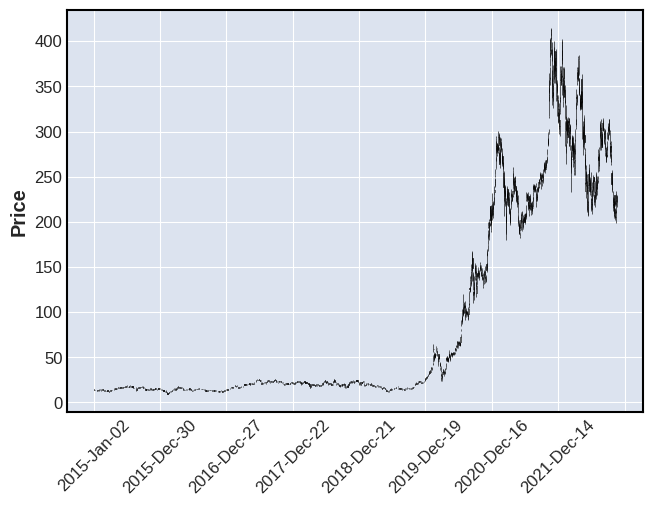

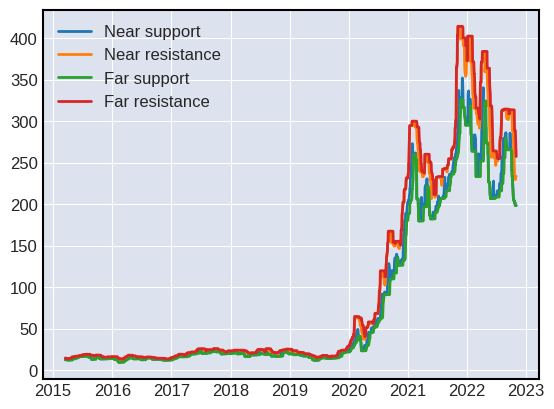

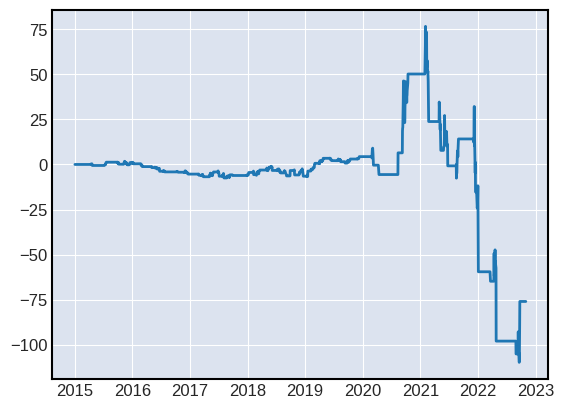

In [ ]:
algo.plot2(algo.fixed_feed)
algo.plot(algo.fixed_feed)

## SPY

In [4]:
msft = yf.Ticker("SPY")
hist = msft.history(start="2015-01-01", end="2022-11-01")
hist = hist[["Open", "High", "Low", "Close"]]
algo = Grab(hist, 50, 10, 20, True)
algo.trade()
algo.feed.to_csv("spy_optimal_trade_full.csv")
algo.fixed_feed.to_csv("spy_fixed_trade_full.csv")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




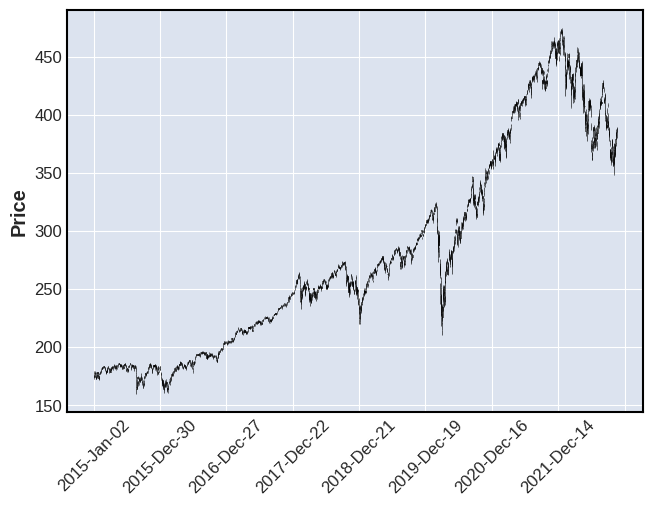

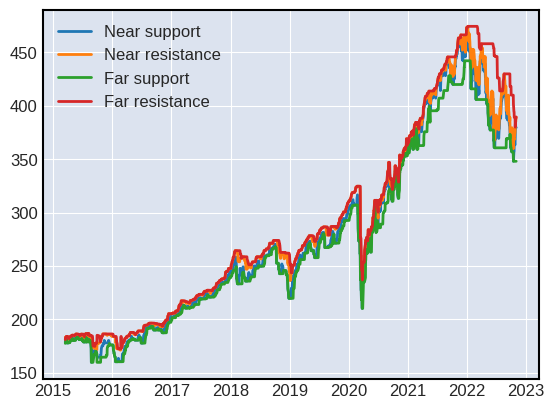

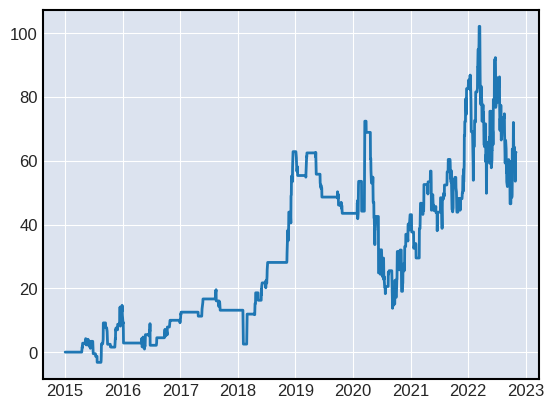

In [5]:
algo.plot2(algo.feed)
algo.plot(algo.feed)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:93: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




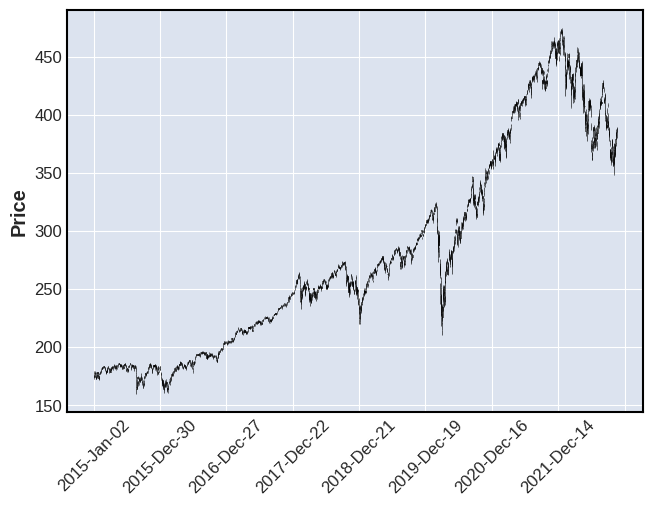

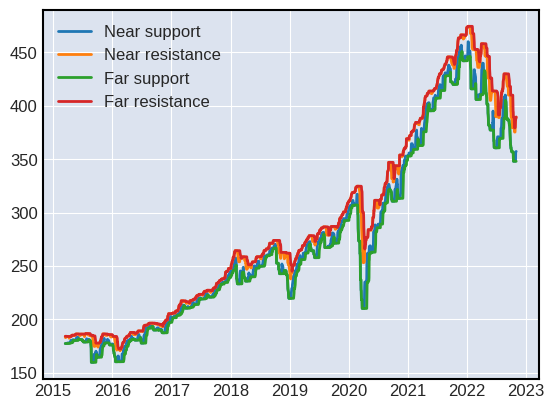

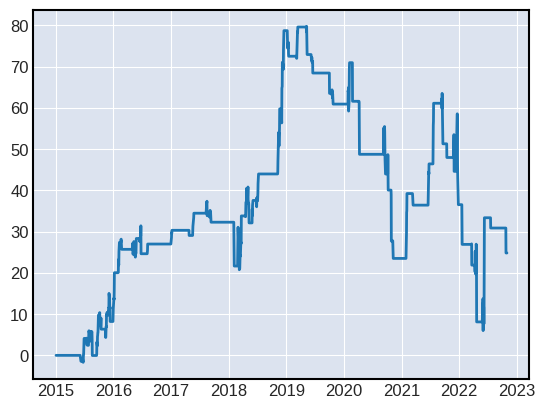

In [6]:
algo.plot2(algo.fixed_feed)
algo.plot(algo.fixed_feed)